## 10-Armed Testbed
### Multi-Armed Bandits simulation for different levels of exploration (epsilon)

In [1]:
import matplotlib
import numpy as np
import random
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
standard_deviation = 1
mean = 0
K = 10

In [3]:
bandit_reward_means = np.random.normal(mean, standard_deviation, K)
data = [np.random.normal(bandit_reward_mean, standard_deviation, 2000) for bandit_reward_mean in bandit_reward_means]

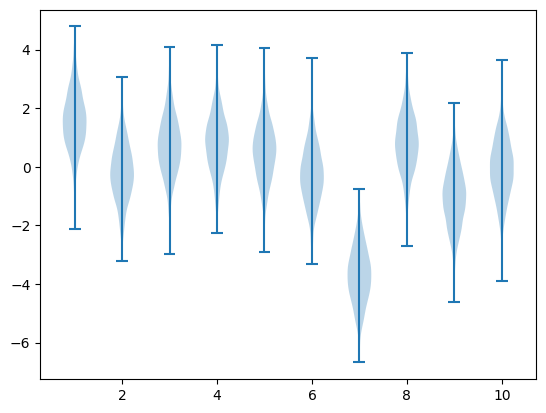

In [4]:
plt.violinplot(dataset=data)
plt.show()

In [5]:
class Run():
    def __init__(self, K, epsilon, mean, standard_deviation, steps, bandit_reward_means=None):
        self.steps = steps
        self.epsilon = epsilon
        self.K = K
        self.observed_rewards_table = [0 for i in range(self.K)]
        self.observed_counts_table = [0 for i in range(self.K)]
        self.rewards_mean = mean
        self.standard_deviation = standard_deviation
        if bandit_reward_means is None:
            self.bandit_reward_means = np.random.normal(self.rewards_mean, self.standard_deviation, self.K)
        else:
            self.bandit_reward_means = bandit_reward_means

        self.control_pane = {'num_explore':0}

    def choose_bandit(self):
        if random.random() < self.epsilon:
            # explore
            chosen_bandit_idx = math.floor(self.K*random.random())
            self.control_pane['num_explore'] += 1
            # print(f"explore - {chosen_bandit_idx}")
        else:
            # exploit
            chosen_bandit_idx = np.argmax(self.observed_rewards_table)
            # print(self.observed_rewards_table)
            # print(f"exploit - {chosen_bandit_idx}")

        self.observed_counts_table[chosen_bandit_idx] += 1
        return chosen_bandit_idx

    def draw_bandit_observation(self, chosen_bandit_idx):
        bandit_mean = self.bandit_reward_means[chosen_bandit_idx]
        # print(bandit_mean)
        bandit_std = self.standard_deviation

        return np.random.normal(bandit_mean, bandit_std, 1)

    def update_bandit_reward(self, bandit_idx, Rn):
        n = self.observed_counts_table[bandit_idx]
        Qn = self.observed_rewards_table[bandit_idx]

        # Update rule
        Qn_plus_1 = Qn + float(1/n)*(Rn - Qn)

        self.observed_rewards_table[bandit_idx] = Qn_plus_1

    def execute(self, epsilon_idx=None, logger=None, round_number=None, plot_reward=False):
        # print(f"Bandit Reward Means - {self.bandit_reward_means}")
        best_action_idx = np.argmax(self.bandit_reward_means)
        for step in range(self.steps):
            chosen_bandit = self.choose_bandit()
            reward = self.draw_bandit_observation(chosen_bandit)[0]
            # update rewards table
            self.update_bandit_reward(chosen_bandit, reward)

            if logger is not None and round_number is not None:
                logger.log(epsilon_idx, round_number, step, 'reward', reward)
                logger.log(epsilon_idx, round_number, step, 'chosen_best_action', 1) if chosen_bandit == best_action_idx else 0

            if plot_reward:
                plt.scatter(x=step, y=reward, alpha=0.1)


class MetricsLogger():
    def __init__(self, epsilons, num_steps, num_rounds):
        self.logs = {}
        self.epsilons = epsilons
        self.num_steps = num_steps
        self.num_rounds = num_rounds

    def log(self, epsilon_idx, run_number, step_number, metric_name, metric_value):
        if metric_name not in self.logs:
            self.logs[metric_name] = np.ndarray(shape=(len(self.epsilons), self.num_rounds, self.num_steps), dtype=float)

        self.logs[metric_name][epsilon_idx, run_number, step_number] = metric_value

    def plot(self, epsilon_idx, metric_name, label):
        # Assuming metric_logger.logs['reward'] is the ndarray with shape (number_of_rounds, number_of_steps)
        metric = self.logs[metric_name][epsilon_idx]
        # Calculate the average value of each step across the rounds
        average_rewards = np.mean(metric, axis=0)

        # Generate the plot
        plt.plot(average_rewards, marker='.', label=label, alpha=0.7, markersize=1)
        plt.xlabel('Step Number')
        plt.ylabel(f'Average {metric_name}')
        plt.title(f'Average {metric_name} per Step Across Rounds')
        plt.grid(True)
        plt.legend(loc='lower right', framealpha=1)


## Comparison of Exploration and No-Exploration on the same bandit-means config

### Epsilon (0) - No Exploration

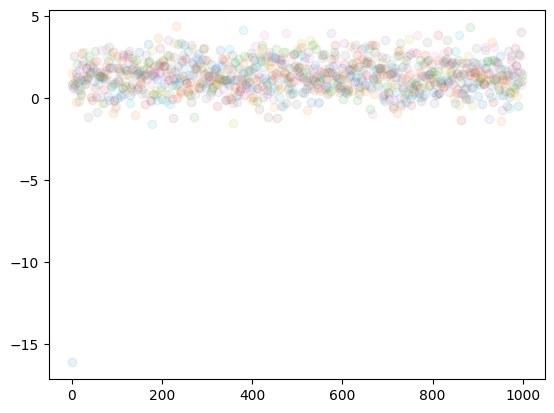

In [9]:
num_steps = 1000
num_rounds = 1
testbed_run = Run(K=10, epsilon=0, mean=0, standard_deviation=1, steps=num_steps, bandit_reward_means=[-15.84414764, 1.39436708 ,  21.50896967,  -3.56027933,  11.17301381, 8.13391559,  14.01262103,   8.94646102,  -6.06750791,   4.74529275])
testbed_run.execute(plot_reward=True)

### Epsilon (0.01) - Some Exploration

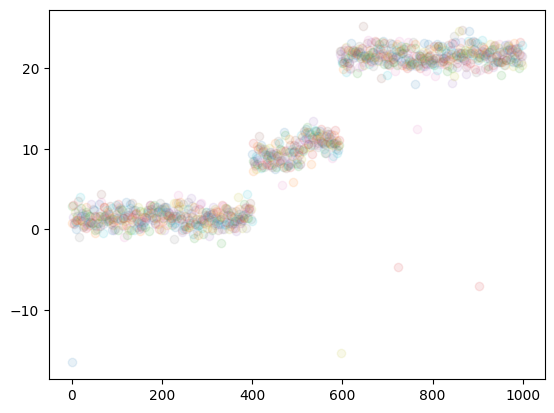

In [11]:
num_steps = 1000
num_rounds = 1
testbed_run = Run(K=10, epsilon=0.01, mean=0, standard_deviation=1, steps=num_steps, bandit_reward_means=[-15.84414764, 1.39436708 ,  21.50896967,  -3.56027933,  11.17301381, 8.13391559,  14.01262103,   8.94646102,  -6.06750791,   4.74529275])
testbed_run.execute(plot_reward=True)

As can be seen, with some exploration, the system starts to learn the best action, as can be seen with the better reward accumulation

## Comparison of Mean Rewards across different epsilon values

In [12]:
num_steps = 10000
num_rounds = 2000
epsilons = [0, 0.001, 0.01, 0.1, 0.5, 0.9]
metric_logger = MetricsLogger(epsilons=epsilons, num_steps=num_steps, num_rounds=num_rounds)

for epsilon_idx, epsilon in enumerate(epsilons):

    for round in tqdm(range(num_rounds)):
        testbed_run = Run(K=10, epsilon=epsilon, mean=0, standard_deviation=1, steps=num_steps)
        testbed_run.execute(epsilon_idx=epsilon_idx, logger=metric_logger, round_number=round)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

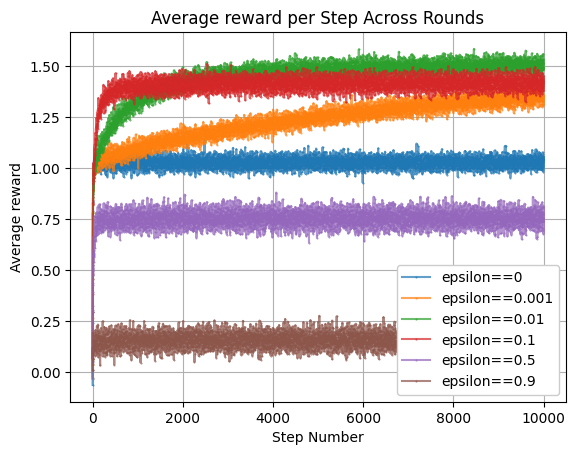

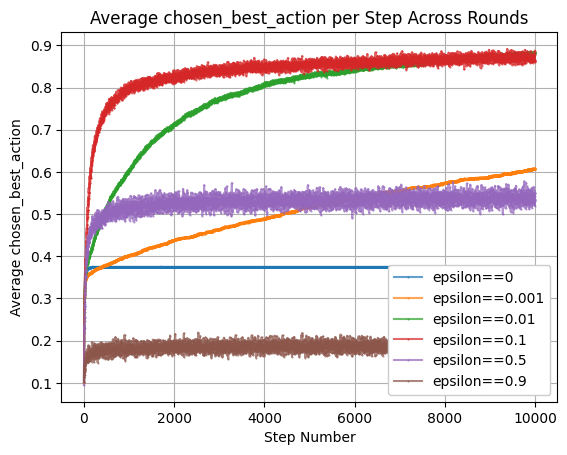

In [13]:
for epsilon_idx, epsilon in enumerate(epsilons):
    metric_logger.plot(epsilon_idx=epsilon_idx, metric_name='reward', label=f'epsilon=={epsilon}')
plt.show()

for epsilon_idx, epsilon in enumerate(epsilons):
    metric_logger.plot(epsilon_idx=epsilon_idx, metric_name='chosen_best_action', label=f'epsilon=={epsilon}')
plt.show()

As can be seen -
- some exploration is better than no exploration
- too much exploration is sub-optimal